### Data

In [1]:
%cd SOICTHackathon2024

[Errno 2] No such file or directory: 'SOICTHackathon2024'
/home/quangminh/Documents/code/Python/SOICTHackathon2024


In [2]:
import os 

In [3]:
train_folder = 'datasets/train/train'
val_folder = 'datasets/train/validation'

In [4]:
train_img_list = os.listdir(train_folder + '/images')

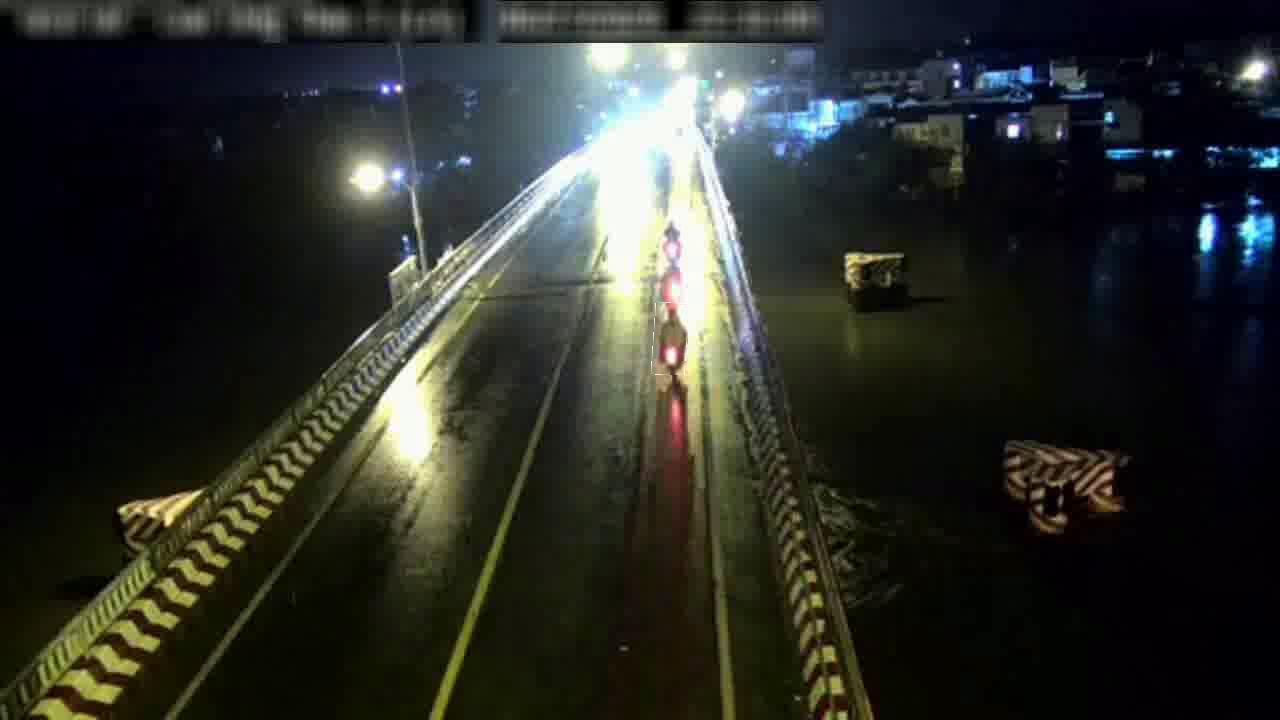

In [5]:
from PIL import Image
from IPython.display import display

im = Image.open(train_folder + '/images/' + train_img_list[25])
width, height = im.size
display(im)

In [6]:
print(width, height)

1280 720


In [7]:
from torch.utils.data import Dataset
from torchvision import transforms
from ultralytics.engine.trainer import BaseTrainer
import cv2
import torch 


class CustomYOLODataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size=640):
        """
        Custom dataset for YOLO.

        Args:
            images_dir (str): Directory with images.
            labels_dir (str): Directory with label files.
            img_size (int): Target image size (YOLO often expects square images).
            transform (callable, optional): Optional transform to apply to images.
        """
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.img_size = img_size
        self.transform =  transforms.Compose([
                        transforms.Resize((640, 640)),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor()
                    ])
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize image to target size
        image = cv2.resize(image, (self.img_size, self.img_size))
        
        # Load label
        label_path = os.path.join(self.labels_dir, self.image_files[idx].replace('.jpg', '.txt'))

        # Convert image to tensor and normalize
        image = torch.from_numpy(image).float() / 255.0  # Normalize to [0,1]
        image = image.permute(2, 0, 1)  # Change to (C, H, W) format for PyTorch

        # Apply any data transformations
        if self.transform:
            image = self.transform(image)
        
        boxes = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                label = line.strip().split()
                # YOLO labels: [class, x_center, y_center, width, height]
                class_id = int(label[0])
                x_center, y_center, width, height = map(float, label[1:])
                boxes.append([class_id, x_center, y_center, width, height])

        return image, boxes


### Model

In [8]:
import torch 
print(torch.cuda.is_available())

True


In [9]:
%pip install -U ultralytics

Note: you may need to restart the kernel to use updated packages.


In [10]:
from ultralytics import YOLO, settings

In [11]:
print(settings)

JSONDict("/home/quangminh/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "288e0b2b0a213dec20ec52bec1e49eb19387b36ea96f2042338a72c0bcf1dedf",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": true,
  "vscode_msg": true
}


In [12]:
# Update multiple settings
settings.update({"datasets_dir": "/home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets", 
                 "tensorboard": False, 
                 "wandb": True})


In [13]:
# Load a model
model = YOLO("/home/quangminh/Documents/code/Python/SOICTHackathon2024/runs/detect/train3/weights/epoch20.pt")  # model name


# Data transformation
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Train the model
train_results = model.train(
    data="/home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/train_data.yaml",  # path to dataset YAML
    epochs=100,  # number of training epochs
    imgsz=640,  # training image size
    device="cuda",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
    batch=16,  # batch size
    workers=8,  # number of 
    dropout=0.1,  # dropout ratio,
    save_period=10,  # save model every 10 epochs,
    # name = 'train',  # name of the run
    resume=True,  # resume training from a model with a checkpoint file,
    seed=42  # random seed,
)



# # Evaluate model performance on the validation set
# metrics = model.val()

# # Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model  

SyntaxError: '[31m[1mdata_transforms[0m' is not a valid YOLO argument. 

    Arguments received: ['yolo', '--f=/home/quangminh/.local/share/jupyter/runtime/kernel-v2-3658xlkPla01gdsI.json']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of {'detect', 'segment', 'obb', 'classify', 'pose'}
                MODE (required) is one of {'predict', 'val', 'benchmark', 'train', 'export', 'track'}
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo train data=coco8.yaml model=yolo11n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at image size 320:
        yolo predict model=yolo11n-seg.pt source='https://youtu.be/LNwODJXcvt4' imgsz=320

    3. Val a pretrained detection model at batch-size 1 and image size 640:
        yolo val model=yolo11n.pt data=coco8.yaml batch=1 imgsz=640

    4. Export a YOLO11n classification model to ONNX format at image size 224 by 128 (no TASK required)
        yolo export model=yolo11n-cls.pt format=onnx imgsz=224,128
    
    5. Streamlit real-time webcam inference GUI
        yolo streamlit-predict
        
    6. Run special commands:
        yolo help
        yolo checks
        yolo version
        yolo settings
        yolo copy-cfg
        yolo cfg

    Docs: https://docs.ultralytics.com
    Community: https://community.ultralytics.com
    GitHub: https://github.com/ultralytics/ultralytics
     (<string>)

In [ ]:
print("Training results:", train_results)

NameError: name 'train_results' is not defined

In [ ]:
import pandas as pd

res = pd.DataFrame(pd.read_csv('runs/detect/train2/results.csv'))
res

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,156.476,1.57014,2.23209,1.13217,0.17118,0.47967,0.14386,0.09317,1.32547,6.72953,1.03831,0.003328,0.003328,0.003328
1,2,304.797,1.44207,1.36805,1.08262,0.17374,0.65096,0.17476,0.11694,1.29081,6.81871,1.01855,0.006595,0.006595,0.006595
2,3,449.044,1.42673,1.25704,1.07289,0.16883,0.65423,0.16886,0.11248,1.29944,5.90764,1.02998,0.009796,0.009796,0.009796
3,4,592.880,1.40935,1.15993,1.07226,0.17193,0.67592,0.17845,0.12002,1.25995,5.82877,1.01666,0.009703,0.009703,0.009703
4,5,735.969,1.36534,1.08038,1.05600,0.17272,0.71260,0.17743,0.12015,1.25016,5.83561,1.00730,0.009604,0.009604,0.009604
5,6,879.491,1.33163,1.01703,1.04597,0.17883,0.70436,0.18053,0.12549,1.20808,6.96025,0.99414,0.009505,0.009505,0.009505
6,7,1022.520,1.30659,0.97242,1.03960,0.17932,0.71744,0.19073,0.13601,1.18111,6.17763,0.98832,0.009406,0.009406,0.009406
7,8,1171.030,1.28765,0.95373,1.03079,0.17596,0.75294,0.18613,0.13281,1.18747,5.32877,0.98353,0.009307,0.009307,0.009307
8,9,1317.150,1.27371,0.92835,1.02336,0.17828,0.74032,0.19620,0.14204,1.15105,4.84775,0.97245,0.009208,0.009208,0.009208
9,10,1460.060,1.25950,0.91234,1.01821,0.18143,0.74805,0.19201,0.14071,1.14252,5.62074,0.96776,0.009109,0.009109,0.009109


In [ ]:
import matplotlib.pyplot as plt
def plot(res):
    plt.figure(figsize=(16, 8))
    plt.plot(res["epoch"], res["metrics/mAP50(B)"], label="mAP50(B)")
    plt.plot(res["epoch"], res["metrics/mAP50-95(B)"], label="mAP50-95(B)")
    plt.plot(res["epoch"], res["train/box_loss"], label="box_loss")
    plt.plot(res["epoch"], res["train/cls_loss"], label="cls_loss")

    plt.xlabel("Epoch")
    plt.ylabel("Metrics")
    plt.title("Training Metrics Over Epochs")
    plt.legend()
    plt.show()

plot(res)

<Figure size 1600x800 with 1 Axes>

In [ ]:
import numpy as np
# Plotting the mAP50(B) metric
print(np.array(res["metrics/mAP50(B)"]))
plt.figure(figsize=(8, 8))
plt.plot(np.array(res["metrics/mAP50(B)"]), label="mAP50(B)")

# Uncomment if you want to plot additional metrics
# plt.plot(res["epoch"], res["metrics/mAP50-95(B)"], label="mAP50-95(B)")
# plt.plot(res["epoch"], res["train/box_loss"], label="box_loss")
# plt.plot(res["epoch"], res["train/cls_loss"], label="cls_loss")

plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.title("Training Metrics Over Epochs")
plt.legend()
plt.show()